# Multiplexed shRNA screening AP009 analytics

Biao Li

This notebook includes analysis scripts of processing count table of multiplexed shRNA screening experiments on AP009 cell line received from Cellecta, and evaluating 
* whether multi-shRNA system works as expected
* prognostic effect of genotype X, and
* predictive effect of genetype X on response to treatment

Note - bash commands to convert notebook to pdf:

$>$ `jupyter nbconvert --to latex multi_shrna_screening_ap009.ipynb`

$>$ `xelatex multi_shrna_screening_ap009.tex`


## Setup path to project directory
This should be absolute path to where project is saved at as a git repo. 

Subfolders of the project directory should be `code`, `data`, `app`, etc.

In [3]:
proj_dir = "~/Documents/Projects/Multi_shRNA_screening_AP009/"

## (ToDos)

* 0 - separate D18-B (technical replicate of D18-A) from the analysis
* 1 - polish up ordering of conditions in plots
* 2 - for each target gene, aggregate across multiple shRNAs
  * currently evaluating each shRNA of each target gene separately
* 3 - spot check QC'ing fastq processing to validate Cellecta's count table
  * also inquiring about counts of clonal barcodes
* 4 - check correlation between cell counts and plasmid counts of all shRNAs for each of pre-Tx NoDox samples 

## (FIXME!)
* Add correlation plots between baseline condition and plasmid counts per target
* Changes made
  * log2 transform ratio of ratios such that under the alternative hypothesis Score != 0, a positive sign suggests that cells with a particular shRNA are more resistant than cells of NT shRNAs, while a negative sign suggests cells are more sensitive
  * Use nonparametric bootstrapping to derive null distribution of median (among 10 shRNAs) prognostic and predictive effect
  * Add analytics/figures similar to Fig.2 D and Fig. 7 of Ian's NatComm 2023 paper
  * RCC (relative cell count) converted back to RTN (relative tumor-cell number)

In [4]:
!pip install matplotlib_venn --trusted-host pypi.python.org --trusted-host pypi.org --trusted-host files.pythonhosted.org

## Dependency pkgs

In [134]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy.stats import pearsonr

from matplotlib_venn import venn3
import matplotlib.patches as patches
from adjustText import adjust_text

# import utility functions
from utility_functions import *

# seed of random number generator
rng_seed = 1234

## Experimental design and parameters

Load experimental design xlsx file (from Ian)
* Master list tab of target genes, vector types, and annotations
* Experimental design tab of groups and samples
  
Load sample description xlsx file (from Cellecta)
* Actual Sample ID and description on flowcell, and inferred information of Group, Day_Tx, Replicate, Dox, etc.

Also check out schematic workflow of experimental design (from Zheng)

![multiplexed shRNA screening experiment](schematic_workflow_experimental_design.png)

In [6]:
# #### experimental design xlsx file
# file_path = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/Multiplexed shRNA screen in 2D AP009 - Cellecta.xlsx"

# xls = pd.ExcelFile(file_path)

# ## Gene targets
# gene_targets_df = pd.read_excel(xls, sheet_name="Master list")
# # Filter out "Individual dual shRNA vector" from gene targets
# filtered_gene_targets_df = gene_targets_df[gene_targets_df["Vector type"] != "Individual dual shRNA vector"]
# filtered_gene_targets = filtered_gene_targets_df["Mouse gene symbol"].dropna().unique()

# # ## Define experimental parameters
# # # Num clonal barcodes per gene
# # num_clonal_barcodes = 12000  
# # # Num shRNAs per gene
# # num_shRNAs_per_gene = 10  
# # # N_reps per condition per timepoint
# # num_replicates = 2  

# ## Define experimental conditions and timepoints 
# # available timepoints
# time_points = ["0d", "3d", "6d", "9d"]
# # experimental conditions based on design
# conditions = [
#     "Baseline_NoDox_Vehicle",
#     "Baseline_Dox_PreTx",  # Only at 0d
#     "Prognostic_Dox_Vehicle",
#     "Predictive_Dox_7977_LowDose",  # IC30 early, IC50 later
#     "Predictive_Dox_7977_HighDose"  # IC90
# ]

In [7]:
#### sample description xlsx file
# file_path_cellecta = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/sample_description_rectified.xlsx"
file_path_cellecta = os.path.join(proj_dir, "data/sample_description_rectified.xlsx")

df_sd = pd.read_excel(file_path_cellecta, sheet_name='Sheet1')

# Set the first row as column headers and remove it from the data
df_sd.columns = df_sd.iloc[0]
df_sd = df_sd[1:].reset_index(drop=True)

# Rename columns to remove any unintended whitespace
df_sd.columns = df_sd.columns.str.strip()

Utility function of table viewing

In [8]:
ViewTable(df_sd, 5)

+-----------+--------------------+----------------+------------------------------------------------+-------------------+---------+-------+--------+-----------+-----+------+
| Sample_ID | Sample_Description |    Library     |                     Vector                     |      Flowcell     |    Tx   | Group | Day_Tx | Replicate | Dox | Note |
+-----------+--------------------+----------------+------------------------------------------------+-------------------+---------+-------+--------+-----------+-----+------+
|     D1    |   T13_Dox_0.6nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   Low   |   5   |   9    |     2     |  Y  | nan  |
|     D2    |   T13_Dox_0.6nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   Low   |   5   |   9    |     1     |  Y  | nan  |
|     D3    |   T13_Dox_3.5nM    | 2.2K-REVMED-ZZ |  pRSIT16cb-U6tet-sh-CMV-tetR-2A-TagRFP-2A-Puro | 25-03-11  102190  |   High  |   4 

## Barcodes (shRNA) count table
Load count table (from Cellecta) and extract fields of sample IDs and target gene

In [9]:
# file_path_count_table = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/Count_Table.csv"
file_path_count_table = os.path.join(proj_dir, "data/Count_Table.csv")

df_counts = pd.read_csv(file_path_count_table)

# Extract columns that start with 'D' plus the 'Gene Symbol / Target Name' column
selected_columns = [col for col in df_counts.columns if col.startswith("D")] + ["Gene Symbol / Target Name"]

# Create a new dataframe with selected columns
df_counts = df_counts[selected_columns].copy()

# Rename 'Gene Symbol / Target Name' to 'target_gene'
df_counts = df_counts.rename(columns={"Gene Symbol / Target Name": "Target_Gene"})

# Rename 'Non-Targeting-Mouse' to 'NT' in the target_gene column
df_counts["Target_Gene"] = df_counts["Target_Gene"].replace("Non-Targeting-Mouse", "NT")

# Ensure there are no NaN values in the target_gene column before counting repeats
df_counts["Target_Gene"] = df_counts["Target_Gene"].fillna("Unknown")

# Generate a sequential ID for each occurrence of target_gene
df_counts["target_gene_repeat_ID"] = df_counts.groupby("Target_Gene").cumcount() + 1

# Format as "01", "02", "03", etc.
df_counts["target_gene_repeat_ID"] = df_counts["target_gene_repeat_ID"].astype(int).apply(lambda x: f"{x:02d}")

# Combine with target_gene to create a unique ID
df_counts["shRNA_ID"] = df_counts["Target_Gene"] + "_" + df_counts["target_gene_repeat_ID"]

# Drop the temporary repeat ID column
df_counts = df_counts.drop(columns=["target_gene_repeat_ID"])

# Update the target_gene_ID column accordingly
df_counts["shRNA_ID"] = df_counts["Target_Gene"] + "_" + df_counts["shRNA_ID"].str.split("_").str[-1]

# melt the dataframe to long format 
df_long = df_counts.melt(id_vars=["Target_Gene", "shRNA_ID"], var_name="Sample_ID", value_name="Read_Counts")

In [10]:
display(df_counts)

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,D17,D18-A,D18-B,D19,D20,D21,D22,D23,Target_Gene,shRNA_ID
0,1399,2777,1312,2281,2056,1579,1072,3116,2532,3019,...,1683,1411,1717,1682,2105,1482,1257,1965,NT,NT_01
1,1785,3277,1776,3414,3139,2482,1289,3877,3373,3953,...,2239,2000,2510,2559,2959,2321,1782,2763,NT,NT_02
2,569,1270,539,1025,1075,892,484,1728,1201,1301,...,727,726,804,774,1094,768,601,945,NT,NT_03
3,955,1703,912,1607,1714,1235,817,2199,1727,2160,...,1234,1153,1372,1268,1481,1010,855,1385,NT,NT_04
4,1150,2403,1177,2281,1981,1467,1055,2641,2071,2504,...,1462,1415,1599,1556,2025,1541,1126,1868,NT,NT_05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182,460,889,548,870,810,571,332,1141,935,1101,...,723,679,758,709,892,658,475,859,Zeb1,Zeb1_06
2183,725,1451,709,1416,1151,1017,483,1693,1601,1726,...,936,782,970,933,1242,931,757,1071,Zeb1,Zeb1_07
2184,547,1133,575,1052,1093,843,477,1365,1246,1497,...,777,771,868,820,1157,698,637,846,Zeb1,Zeb1_08
2185,1354,2584,1371,2570,2230,1773,1047,3223,2530,3248,...,1740,1610,1877,1745,2160,1681,1329,1973,Zeb1,Zeb1_09


In [11]:
display(df_long)

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts
0,NT,NT_01,D1,1399
1,NT,NT_02,D1,1785
2,NT,NT_03,D1,569
3,NT,NT_04,D1,955
4,NT,NT_05,D1,1150
...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859
52484,Zeb1,Zeb1_07,D23,1071
52485,Zeb1,Zeb1_08,D23,846
52486,Zeb1,Zeb1_09,D23,1973


In [12]:
### total number of barcodes per sample / condition

In [13]:
df_full = df_long.merge(df_sd[["Sample_ID", "Sample_Description", "Day_Tx", "Tx", "Dox", "Replicate"]], 
                        left_on = "Sample_ID", right_on = "Sample_ID", how = "left")
# df_full.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/long_format_joint_count_data.csv", index = False)
df_full.to_csv(os.path.join(proj_dir, "data/long_format_joint_count_data.csv"), index = False)

In [14]:
display(df_full)
print(df_full["Target_Gene"].value_counts())

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2
...,...,...,...,...,...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859,T4_Dox_NoTx,0,None,Y,1
52484,Zeb1,Zeb1_07,D23,1071,T4_Dox_NoTx,0,None,Y,1
52485,Zeb1,Zeb1_08,D23,846,T4_Dox_NoTx,0,None,Y,1
52486,Zeb1,Zeb1_09,D23,1973,T4_Dox_NoTx,0,None,Y,1


NT               4800
Pdgfra            240
Nf1               240
Nf2               240
Nfe2l2            240
                 ... 
Erbb2             240
Erbb3             240
Ern1              240
Zeb1              240
Cdkn2a(Ink4a)     168
Name: Target_Gene, Length: 200, dtype: int64


Plot total read counts per sample

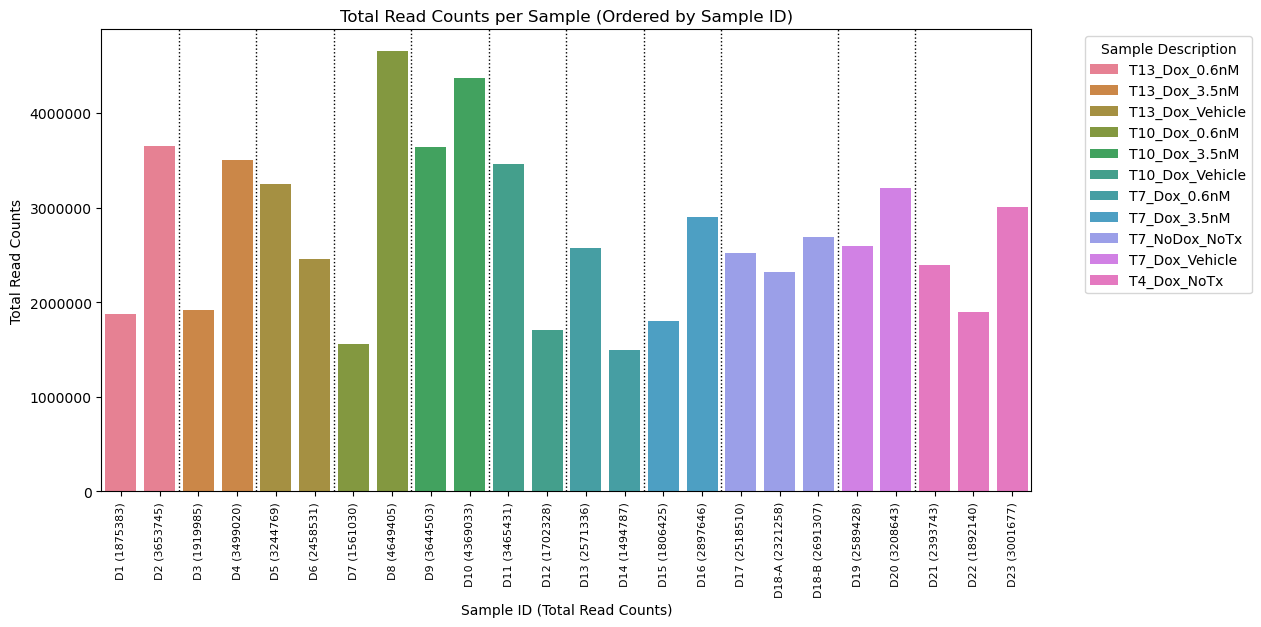

In [15]:
# Aggregate total read counts per sample
df_sample_counts_simple = df_full.groupby(["Sample_ID", "Sample_Description"])["Read_Counts"].sum().reset_index()

# Ensure Sample_ID is sorted numerically rather than lexicographically
df_sample_counts_simple["Sample_ID_Sort"] = df_sample_counts_simple["Sample_ID"].str.extract('(\d+)').astype(int)
df_sample_counts_simple = df_sample_counts_simple.sort_values(by="Sample_ID_Sort").reset_index()

# Modify Sample_ID labels to include total counts in parentheses
df_sample_counts_simple["Sample_ID_Label"] = df_sample_counts_simple.apply(
    lambda row: f"{row['Sample_ID']} ({int(row['Read_Counts'])})", axis=1
)

# Plot the bar chart with modified x-axis labels
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_sample_counts_simple, x="Sample_ID_Label", y="Read_Counts", hue="Sample_Description", dodge=False)

# Identify group transitions for adding vertical dotted lines
prev_desc = None
for index, row in df_sample_counts_simple.iterrows():
    current_desc = row["Sample_Description"]
    if prev_desc is not None and prev_desc != current_desc:
        plt.axvline(x=index - 0.5, color="black", linestyle="dotted", linewidth=1)  # Add vertical separator
    prev_desc = current_desc

# Set y-axis to exact number format
plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation

plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Sample ID (Total Read Counts)")
plt.ylabel("Total Read Counts")
plt.title("Total Read Counts per Sample (Ordered by Sample ID)")
plt.legend(title="Sample Description", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.show()


## Non-targeting shRNAs quantification and selection
Assuming that for each non-targeting shRNA, its reads proportion should be minimally variable among replicates of each experimental condition (as denoted by `Sample_Description` field of `df_full`

In [16]:
# Reload full count table
# df_full_path = "~/Documents/Projects/Multi_shRNA_screening_AP009/data/long_format_joint_count_data.csv"
df_full_path = os.path.join(proj_dir, "data/long_format_joint_count_data.csv")

df_full = pd.read_csv(df_full_path)

# Filter for only NT (Non-Targeting) shRNAs
df_nt = df_full[df_full["Target_Gene"] == "NT"]

# Compute total counts per sample
df_total_counts = df_full.groupby("Sample_ID")["Read_Counts"].sum().reset_index()
df_total_counts = df_total_counts.rename(columns={"Read_Counts": "Total_Read_Counts"})

# Merge total counts back to the NT dataset
df_nt = df_nt.merge(df_total_counts, on="Sample_ID", how="left")

# Compute relative proportion for each shRNA within each sample
df_nt["Relative_Proportion"] = df_nt["Read_Counts"] / df_nt["Total_Read_Counts"]

In [17]:
display(df_nt)
print(df_nt["Target_Gene"].value_counts())

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate,Total_Read_Counts,Relative_Proportion
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000746
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000952
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000303
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000509
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2,1875383,0.000613
...,...,...,...,...,...,...,...,...,...,...,...
4795,NT,NT_196,D23,3103,T4_Dox_NoTx,0,None,Y,1,3001677,0.001034
4796,NT,NT_197,D23,1325,T4_Dox_NoTx,0,None,Y,1,3001677,0.000441
4797,NT,NT_198,D23,991,T4_Dox_NoTx,0,None,Y,1,3001677,0.000330
4798,NT,NT_199,D23,1613,T4_Dox_NoTx,0,None,Y,1,3001677,0.000537


NT    4800
Name: Target_Gene, dtype: int64


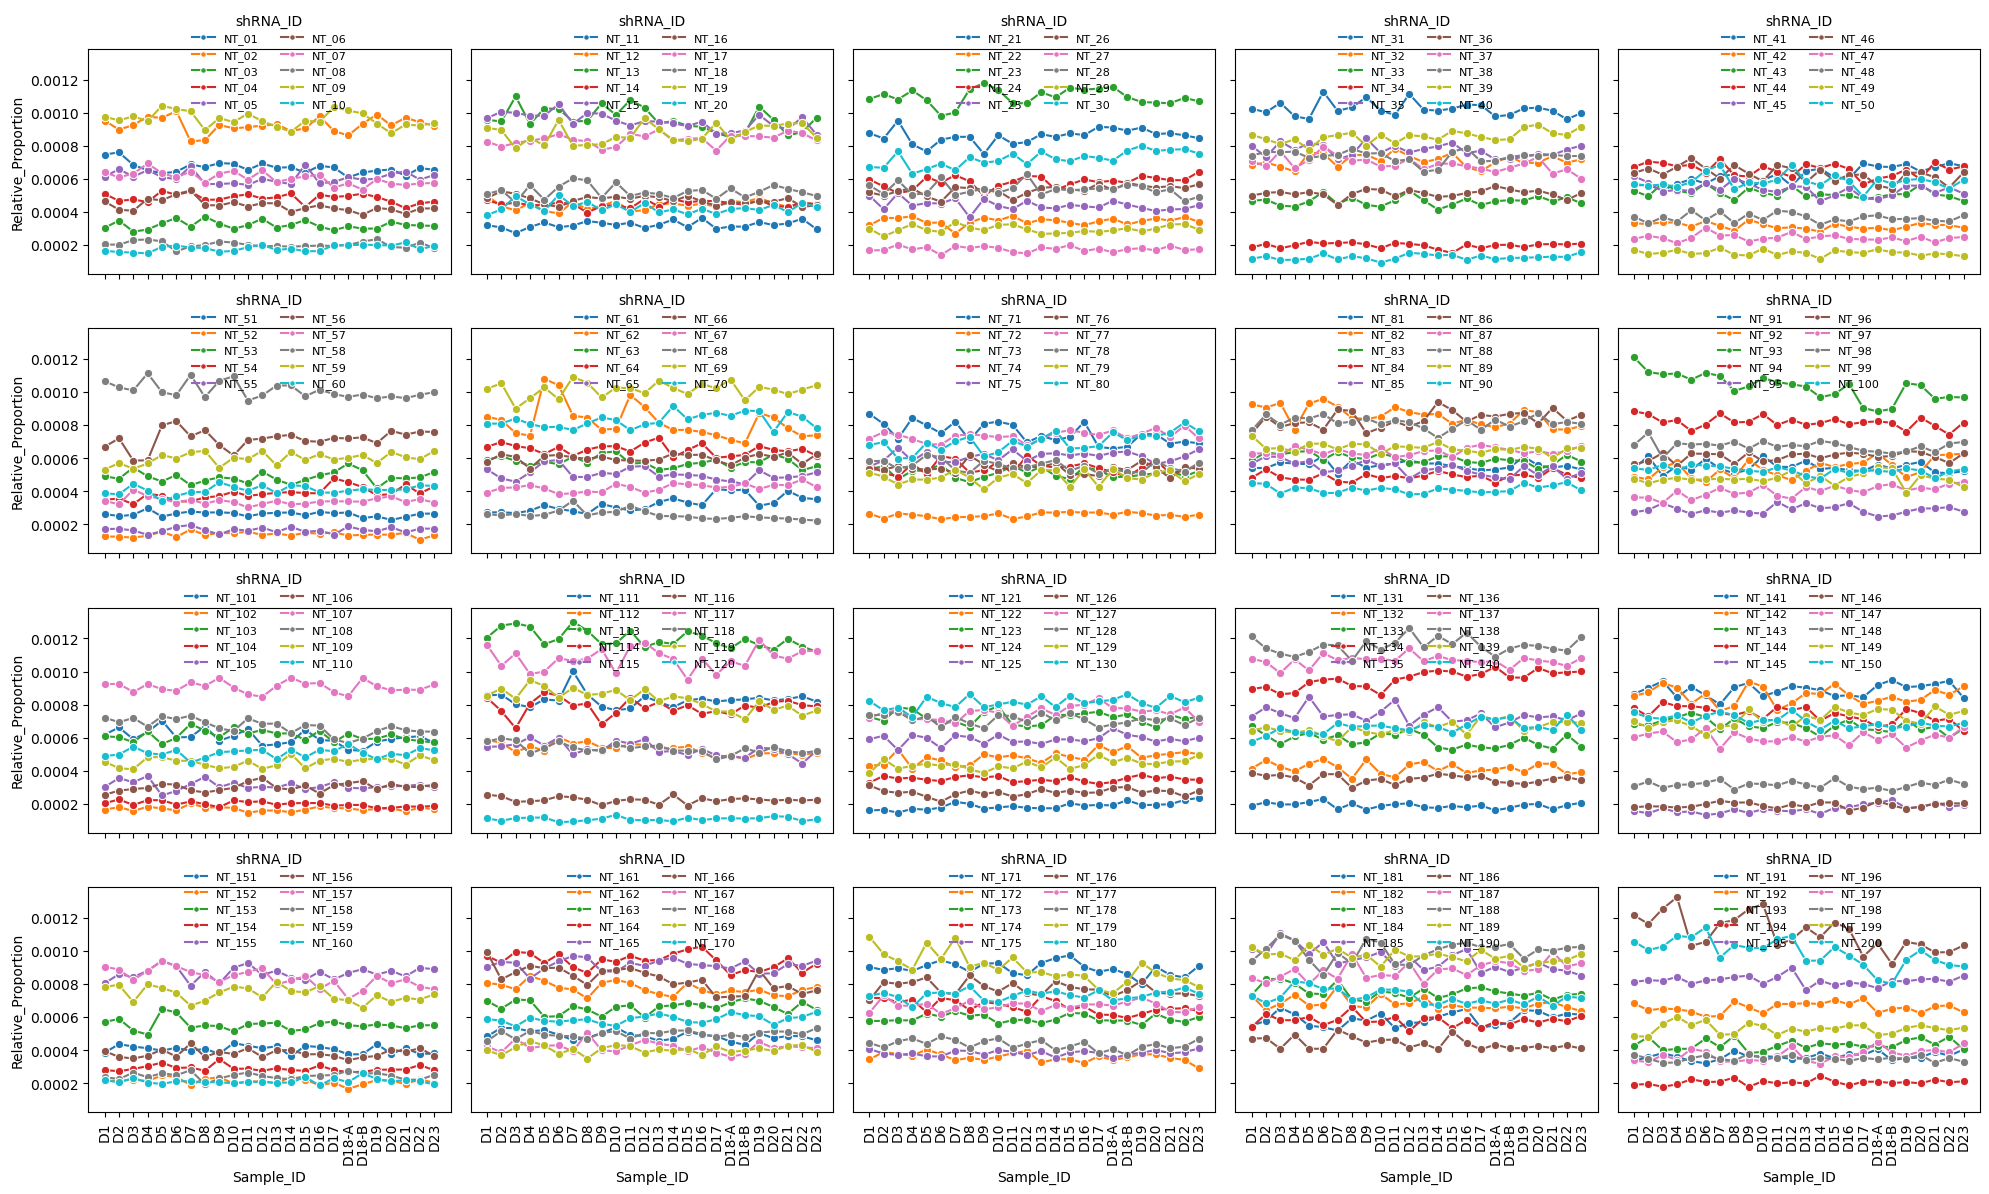

In [18]:
# Get unique shRNA_IDs
unique_shRNAs = df_nt["shRNA_ID"].unique()

# Create a 4x5 subplot grid 
fig, axes = plt.subplots(4, 5, figsize=(20, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten 2D array of subplots

# Plot in batches of 10 shRNAs per subplot
batch_size = 10
for i in range(0, len(unique_shRNAs), batch_size):
    shRNA_subset = unique_shRNAs[i:i + batch_size]
    ax = axes[i // batch_size]
    
    sns.lineplot(data=df_nt[df_nt["shRNA_ID"].isin(shRNA_subset)],
                 x="Sample_ID", y="Relative_Proportion", hue="shRNA_ID", marker="o", ax=ax)
    
    ax.tick_params(axis='x', rotation=90)
    
    # Move legend on top of each subplot and shrink marker size to avoid clutter
    legend = ax.legend(title="shRNA_ID", bbox_to_anchor=(0.5, 1.2), loc="upper center", fontsize=8, ncol=2, frameon=False)
    for line in legend.get_lines():
        line.set_markersize(4)  # Reduce marker size

# Adjust layout
plt.tight_layout()
plt.show()


Quantifying CV of reads proportion for each NT shRNA among samples within each experimental condition of `Sample_Description`

In [19]:
# Group by shRNA within each Sample_Description
df_nt_variation = df_nt.groupby(["shRNA_ID", "Sample_Description"])["Relative_Proportion"].agg(
    Mean_Proportion="mean",
    Std_Proportion="std"
).reset_index()

# Compute Coefficient of Variation (CV)
df_nt_variation["CV"] = df_nt_variation["Std_Proportion"] / df_nt_variation["Mean_Proportion"]


In [20]:
display(df_nt_variation)
# df_nt_variation.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/non_targeting_shrna_variation_table.csv", index = False)
df_nt_variation.to_csv(os.path.join(proj_dir, "data/non_targeting_shrna_variation_table.csv"), index = False)

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231
1,NT_01,T10_Dox_3.5nM,0.000693,0.000003,0.003822
2,NT_01,T10_Dox_Vehicle,0.000673,0.000028,0.041265
3,NT_01,T13_Dox_0.6nM,0.000753,0.000010,0.013204
4,NT_01,T13_Dox_3.5nM,0.000668,0.000022,0.033302
...,...,...,...,...,...
2195,NT_99,T4_Dox_NoTx,0.000457,0.000028,0.061696
2196,NT_99,T7_Dox_0.6nM,0.000470,0.000032,0.068284
2197,NT_99,T7_Dox_3.5nM,0.000461,0.000037,0.080397
2198,NT_99,T7_Dox_Vehicle,0.000444,0.000075,0.167892


In [21]:
display(df_nt_variation[df_nt_variation["Sample_Description"] == "T10_Dox_0.6nM"])

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231
11,NT_02,T10_Dox_0.6nM,0.000830,0.000006,0.006931
22,NT_03,T10_Dox_0.6nM,0.000341,0.000044,0.127808
33,NT_04,T10_Dox_0.6nM,0.000498,0.000036,0.071551
44,NT_05,T10_Dox_0.6nM,0.000622,0.000076,0.122570
...,...,...,...,...,...
2145,NT_95,T10_Dox_0.6nM,0.000277,0.000010,0.035703
2156,NT_96,T10_Dox_0.6nM,0.000595,0.000042,0.070011
2167,NT_97,T10_Dox_0.6nM,0.000403,0.000026,0.063755
2178,NT_98,T10_Dox_0.6nM,0.000689,0.000017,0.025127


Boxplot of CV of `df_nt_variation` across NT shRNAs

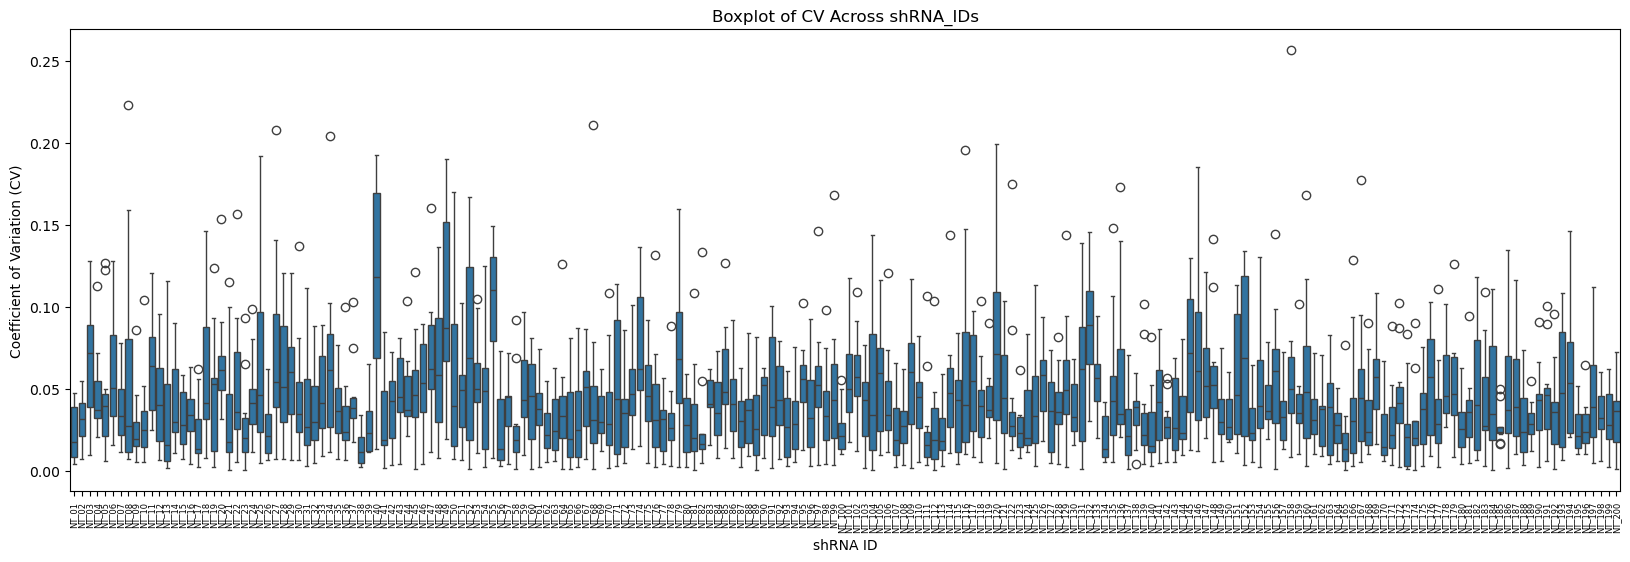

In [22]:
# Extract numeric part of shRNA_ID and sort sequentially from 1 to 200
df_nt_variation["shRNA_Seq"] = df_nt_variation["shRNA_ID"].str.extract(r'(\d+)').astype(int)
df_nt_variation = df_nt_variation.sort_values(by="shRNA_Seq")

# Create a wider boxplot with ordered shRNA_IDs
plt.figure(figsize=(20, 6))
sns.boxplot(data=df_nt_variation, x="shRNA_ID", y="CV")

# Customize the plot
plt.xticks(rotation=90, fontsize=6)  # Smaller font size for x-axis labels
plt.xlabel("shRNA ID")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("Boxplot of CV Across shRNA_IDs")

# Show the plot
plt.show()

Barchart of Median CV of `df_nt_variation` across NT shRNAs with bootstrapped confience internal

In [23]:
# Compute median and bootstrapped confidence intervals for each shRNA_ID
df_cv_stats = df_nt_variation.groupby("shRNA_ID")["CV"].agg(
    Median_CV="median"
).reset_index()

# Apply bootstrapping for confidence intervals
df_cv_stats["Lower_CI"], df_cv_stats["Upper_CI"] = zip(*df_nt_variation.groupby("shRNA_ID")["CV"].apply(lambda x: bootstrap_median_ci(x)))

# Calculate error bars (difference between median and lower/upper bounds)
df_cv_stats["Error_Lower"] = df_cv_stats["Median_CV"] - df_cv_stats["Lower_CI"]
df_cv_stats["Error_Upper"] = df_cv_stats["Upper_CI"] - df_cv_stats["Median_CV"]


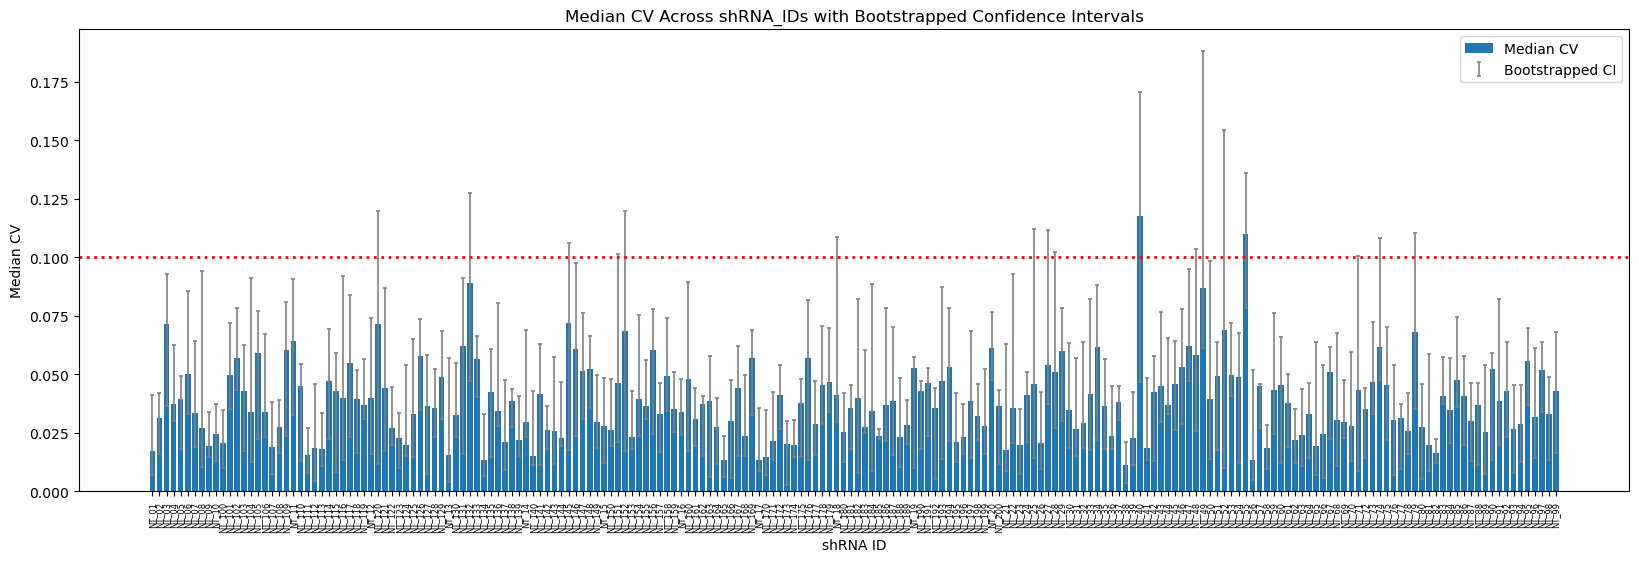

In [24]:
# Create a bar chart with bootstrapped confidence intervals
plt.figure(figsize=(20, 6))

# Plot bars for Median_CV
plt.bar(df_cv_stats["shRNA_ID"], df_cv_stats["Median_CV"], label="Median CV")

# Add error bars with small caps at both ends
plt.errorbar(df_cv_stats["shRNA_ID"], df_cv_stats["Median_CV"], 
             yerr=[df_cv_stats["Error_Lower"], df_cv_stats["Error_Upper"]], 
             fmt='none', ecolor="gray", elinewidth=1.2, capsize=1.5, capthick=1.2, label="Bootstrapped CI")
plt.axhline(y=0.1, color='red', linestyle='dotted', linewidth=2)
# Customize the plot
plt.xticks(rotation=90, fontsize=6)
plt.xlabel("shRNA ID")
plt.ylabel("Median CV")
plt.title("Median CV Across shRNA_IDs with Bootstrapped Confidence Intervals")
plt.legend()

# Show the plot
plt.show()


There are 183 NT shRNA whose bootstrapped confidence internals of median CVs < 0.1

In [25]:
df_selected_nt_boot_median = df_cv_stats[(df_cv_stats["Upper_CI"] < 0.1)]
display(df_selected_nt_boot_median)
# df_selected_nt_boot_median.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/selected_non_targeting_shRNA_table_median_cv_bootstrapped.csv", index = False)
df_selected_nt_boot_median.to_csv(os.path.join(proj_dir, "data/selected_non_targeting_shRNA_table_median_cv_bootstrapped.csv"), index = False)

,shRNA_ID,Median_CV,Lower_CI,Upper_CI,Error_Lower,Error_Upper
0,NT_01,0.017231,0.007015,0.041265,0.010216,0.024034
1,NT_02,0.031408,0.016015,0.042011,0.015393,0.010603
2,NT_03,0.071599,0.036633,0.092930,0.034966,0.021331
3,NT_04,0.037188,0.029977,0.062541,0.007211,0.025353
4,NT_05,0.039316,0.017949,0.049489,0.021367,0.010173
...,...,...,...,...,...,...
195,NT_95,0.055613,0.036926,0.069820,0.018688,0.014206
196,NT_96,0.031795,0.014230,0.061475,0.017565,0.029680
197,NT_97,0.051950,0.033848,0.063755,0.018101,0.011805
198,NT_98,0.033246,0.013237,0.048943,0.020009,0.015697


Quantifying overall variability for each NT shRNA by summarizing mean, median, inter-quartile-range, and max CVs, where 
* mean is the average across all conditions
* median is more robust to outliers
* IQR measures spread
* max captures extreme values

In [26]:
df_nt_cv_summary = df_nt_variation.groupby("shRNA_ID")["CV"].agg(
    Mean_CV="mean",
    Median_CV="median",
    IQR_CV=lambda x: x.quantile(0.75) - x.quantile(0.25),  # Interquartile Range
    Max_CV="max"
).reset_index()


In [27]:
display(df_nt_cv_summary)

,shRNA_ID,Mean_CV,Median_CV,IQR_CV,Max_CV
0,NT_01,0.023505,0.017231,0.030772,0.047327
1,NT_02,0.031011,0.031408,0.019975,0.054954
2,NT_03,0.066902,0.071599,0.050576,0.127808
3,NT_04,0.046917,0.037188,0.022093,0.112538
4,NT_05,0.047722,0.039316,0.025738,0.126396
...,...,...,...,...,...
195,NT_95,0.054365,0.055613,0.021983,0.102406
196,NT_96,0.037031,0.031795,0.041091,0.092345
197,NT_97,0.056563,0.051950,0.024747,0.146140
198,NT_98,0.037734,0.033246,0.029870,0.097928


From a total of 200 non-targeting shRNAs Selecting 49 that have 
* low Mean_CV (ensuring overall low variability) 
* low IQR_CV (ensuring tight distribution of variability)
* filtered out cases of extreme outliers (in case Max_CV >= 3 x Median_CV)

In [28]:
mean_cv_threshold = df_nt_cv_summary["Mean_CV"].quantile(0.5)
iqr_cv_threshold = df_nt_cv_summary["IQR_CV"].quantile(0.5)
max_cv_threshold = df_nt_cv_summary["Max_CV"].quantile(0.8)

df_selected_nt = df_nt_cv_summary[
    (df_nt_cv_summary["Mean_CV"] < mean_cv_threshold) &
    (df_nt_cv_summary["IQR_CV"] < iqr_cv_threshold) &
    (df_nt_cv_summary["Max_CV"] < 3 * df_nt_cv_summary["Median_CV"])
]

print(df_selected_nt.shape)

(49, 5)


In [29]:
display(df_nt_variation)

,shRNA_ID,Sample_Description,Mean_Proportion,Std_Proportion,CV,shRNA_Seq
0,NT_01,T10_Dox_0.6nM,0.000678,0.000012,0.017231,1
1,NT_01,T10_Dox_3.5nM,0.000693,0.000003,0.003822,1
2,NT_01,T10_Dox_Vehicle,0.000673,0.000028,0.041265,1
3,NT_01,T13_Dox_0.6nM,0.000753,0.000010,0.013204,1
4,NT_01,T13_Dox_3.5nM,0.000668,0.000022,0.033302,1
...,...,...,...,...,...,...
1322,NT_200,T10_Dox_Vehicle,0.001081,0.000013,0.011939,200
1321,NT_200,T10_Dox_3.5nM,0.001017,0.000002,0.001932,200
1320,NT_200,T10_Dox_0.6nM,0.000998,0.000055,0.054743,200
1324,NT_200,T13_Dox_3.5nM,0.001059,0.000046,0.043319,200


In [30]:
display(df_selected_nt)
# df_selected_nt.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/selected_non_targeting_shRNA_table.csv", index = False)
df_selected_nt.to_csv(os.path.join(proj_dir, "data/selected_non_targeting_shRNA_table.csv"), index = False)

,shRNA_ID,Mean_CV,Median_CV,IQR_CV,Max_CV
0,NT_01,0.023505,0.017231,0.030772,0.047327
1,NT_02,0.031011,0.031408,0.019975,0.054954
6,NT_07,0.036874,0.033410,0.028563,0.077838
10,NT_100,0.024578,0.020823,0.016112,0.055441
18,NT_108,0.028896,0.027380,0.019566,0.062194
29,NT_118,0.039625,0.039568,0.028879,0.103221
35,NT_123,0.025248,0.022711,0.017982,0.061534
40,NT_128,0.038933,0.035748,0.019580,0.081445
43,NT_130,0.037138,0.032867,0.028425,0.067972
51,NT_138,0.034664,0.038686,0.014556,0.059808


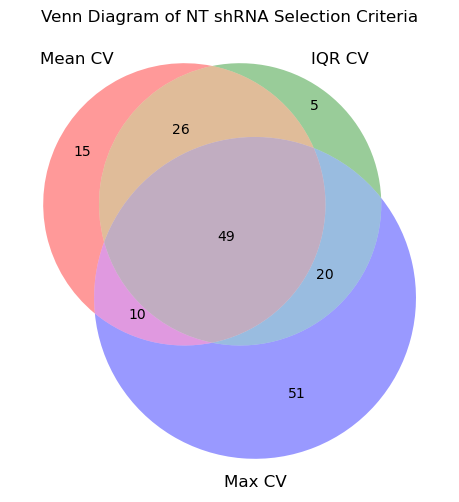

In [31]:
# Define sets for each selection criterion
set_mean_cv = set(df_nt_cv_summary[df_nt_cv_summary["Mean_CV"] < mean_cv_threshold]["shRNA_ID"])
set_iqr_cv = set(df_nt_cv_summary[df_nt_cv_summary["IQR_CV"] < iqr_cv_threshold]["shRNA_ID"])
set_max_cv = set(df_nt_cv_summary[df_nt_cv_summary["Max_CV"] < 3 * df_nt_cv_summary["Median_CV"]]["shRNA_ID"])

# Create Venn diagram
plt.figure(figsize=(6, 6))
venn = venn3([set_mean_cv, set_iqr_cv, set_max_cv], ('Mean CV', 'IQR CV', 'Max CV'))

# Customize colors and labels
plt.title("Venn Diagram of NT shRNA Selection Criteria")
plt.show()

## RTN (relative tumor-cell number) 
For each shRNA (`shRNA_ID`) of each target gene (`Target_Gene`) of each condition (`Sample_Description`), RTN is defined and calculated as ratio of total read counts of the shRNA of the target gene divided by total read counts of (selected) non-target genes

In [32]:
## Create df_full_nt_sel by filtering NT shRNAs based on df_selected_nt (or df_selected_nt_boot_median) and keeping all other target genes
df_full_nt_sel = df_full.copy()

# Use df_selected_nt_boot_median to filter on NT shRNAs
df_nt_filtering = df_selected_nt_boot_median
# df_nt_filtering = df_selected_nt

df_full_nt_sel = df_full_nt_sel[
    (df_full_nt_sel["Target_Gene"] != "NT") |  # Keep all non-NT genes
    ((df_full_nt_sel["Target_Gene"] == "NT") & df_full_nt_sel["shRNA_ID"].isin(df_nt_filtering["shRNA_ID"]))  # Keep only selected NT shRNAs
]
print(df_full_nt_sel.shape)

(52080, 9)


In [33]:
display(df_full_nt_sel)

,Target_Gene,shRNA_ID,Sample_ID,Read_Counts,Sample_Description,Day_Tx,Tx,Dox,Replicate
0,NT,NT_01,D1,1399,T13_Dox_0.6nM,9,Low,Y,2
1,NT,NT_02,D1,1785,T13_Dox_0.6nM,9,Low,Y,2
2,NT,NT_03,D1,569,T13_Dox_0.6nM,9,Low,Y,2
3,NT,NT_04,D1,955,T13_Dox_0.6nM,9,Low,Y,2
4,NT,NT_05,D1,1150,T13_Dox_0.6nM,9,Low,Y,2
...,...,...,...,...,...,...,...,...,...
52483,Zeb1,Zeb1_06,D23,859,T4_Dox_NoTx,0,None,Y,1
52484,Zeb1,Zeb1_07,D23,1071,T4_Dox_NoTx,0,None,Y,1
52485,Zeb1,Zeb1_08,D23,846,T4_Dox_NoTx,0,None,Y,1
52486,Zeb1,Zeb1_09,D23,1973,T4_Dox_NoTx,0,None,Y,1


In [34]:
## Compute sum of Read_Counts for each shRNA_ID of each Target_Gene within each Sample_Description
df_summed_counts = df_full_nt_sel.groupby(["Sample_Description", "Target_Gene", "shRNA_ID", "Day_Tx", "Tx", "Dox"])\
    ["Read_Counts"].sum().reset_index()

In [35]:
display(df_summed_counts)

,Sample_Description,Target_Gene,shRNA_ID,Day_Tx,Tx,Dox,Read_Counts
0,T10_Dox_0.6nM,Abcb1,Abcb1_01,6,Low,Y,1952
1,T10_Dox_0.6nM,Abcb1,Abcb1_02,6,Low,Y,2035
2,T10_Dox_0.6nM,Abcb1,Abcb1_03,6,Low,Y,1532
3,T10_Dox_0.6nM,Abcb1,Abcb1_04,6,Low,Y,4146
4,T10_Dox_0.6nM,Abcb1,Abcb1_05,6,Low,Y,4395
...,...,...,...,...,...,...,...
23865,T7_NoDox_NoTx,Zeb1,Zeb1_06,3,None,N,2160
23866,T7_NoDox_NoTx,Zeb1,Zeb1_07,3,None,N,2688
23867,T7_NoDox_NoTx,Zeb1,Zeb1_08,3,None,N,2416
23868,T7_NoDox_NoTx,Zeb1,Zeb1_09,3,None,N,5227


In [36]:
## Calculate RTNs

# Compute the summed Read_Counts across all NT shRNA_IDs for each Sample_Description
df_nt_summed = df_summed_counts[df_summed_counts["Target_Gene"] == "NT"]\
    .groupby("Sample_Description")["Read_Counts"].sum().reset_index()

df_rtn = df_summed_counts.merge(df_nt_summed, on="Sample_Description", suffixes=("", "_NT"))

# df_rtn = df_summed_counts.merge(
#     df_summed_counts[df_summed_counts["Target_Gene"] == "NT"][["Sample_Description", "Read_Counts"]],
#     on="Sample_Description",
#     suffixes=("", "_NT")
# )

# Compute RTN (Read_Counts / Read_Counts of NT)
df_rtn["RTN"] = df_rtn["Read_Counts"] / df_rtn["Read_Counts_NT"]

# Drop the redundant NT read count column
df_rtn = df_rtn.drop(columns=["Read_Counts_NT"])

In [37]:
display(df_rtn)
# df_rtn.to_csv("~/Documents/Projects/Multi_shRNA_screening_AP009/data/shrna_target_gene_relative_tumor_number_table.csv", index = False)
df_rtn.to_csv(os.path.join(proj_dir, "data/shrna_target_gene_relative_tumor_number_table.csv"), index = False)

,Sample_Description,Target_Gene,shRNA_ID,Day_Tx,Tx,Dox,Read_Counts,RTN
0,T10_Dox_0.6nM,Abcb1,Abcb1_01,6,Low,Y,1952,0.002824
1,T10_Dox_0.6nM,Abcb1,Abcb1_02,6,Low,Y,2035,0.002944
2,T10_Dox_0.6nM,Abcb1,Abcb1_03,6,Low,Y,1532,0.002216
3,T10_Dox_0.6nM,Abcb1,Abcb1_04,6,Low,Y,4146,0.005998
4,T10_Dox_0.6nM,Abcb1,Abcb1_05,6,Low,Y,4395,0.006359
...,...,...,...,...,...,...,...,...
23865,T7_NoDox_NoTx,Zeb1,Zeb1_06,3,None,N,2160,0.002631
23866,T7_NoDox_NoTx,Zeb1,Zeb1_07,3,None,N,2688,0.003274
23867,T7_NoDox_NoTx,Zeb1,Zeb1_08,3,None,N,2416,0.002943
23868,T7_NoDox_NoTx,Zeb1,Zeb1_09,3,None,N,5227,0.006366


In [38]:
print(df_rtn["Sample_Description"].value_counts())

T10_Dox_0.6nM      2170
T10_Dox_3.5nM      2170
T10_Dox_Vehicle    2170
T13_Dox_0.6nM      2170
T13_Dox_3.5nM      2170
T13_Dox_Vehicle    2170
T4_Dox_NoTx        2170
T7_Dox_0.6nM       2170
T7_Dox_3.5nM       2170
T7_Dox_Vehicle     2170
T7_NoDox_NoTx      2170
Name: Sample_Description, dtype: int64


In [39]:
# Split shRNA_ID into two parts: the main ID and the repetition number
df_rtn["shRNA_Rep"] = df_rtn["shRNA_ID"].str.split("_").str[1]


## Prognostic effects 
A vs. B <-> Dox (target gene vs NT) vs. NoDox (target gene vs NT)
* ratio of ratios - `T13_Dox_Vehicle` vs. `T7_NoDox_NoTx`

In [151]:
# Define conditions for A and B
# condition_A = "T7_Dox_Vehicle"
condition_A = "T13_Dox_Vehicle"
condition_B = "T7_NoDox_NoTx"

# Include the Target_Gene field in both condition datasets before merging
df_A = df_rtn[df_rtn["Sample_Description"] == condition_A][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_A"})
df_B = df_rtn[df_rtn["Sample_Description"] == condition_B][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_B"})

# Merge the two datasets on shRNA_ID and Target_Gene
df_prognostic = df_A.merge(df_B, on=["shRNA_ID", "Target_Gene"], how="inner")

# Compute the prognostic effect as log2(RTN_A / RTN_B)
df_prognostic["Prognostic_Effect"] = np.log2(df_prognostic["RTN_A"] / df_prognostic["RTN_B"])

# Define control gene lists
loss_of_representation_target_genes = ["Rpa1", "Rpa3", "Rps6", "Pcna", "Psmc5", "Rbx1", "Ran", "Snrpd1", "Rpl7", "Kif11"]
neutral_control_target_genes = ["NT", "Trp53"]
gain_of_representation_target_genes = ["Pten"]

# Assign categories for sorting
df_prognostic["Gene_Category"] = "Other"  # Default category
df_prognostic.loc[df_prognostic["Target_Gene"].isin(neutral_control_target_genes), "Gene_Category"] = "Neutral Control"
df_prognostic.loc[df_prognostic["Target_Gene"].isin(loss_of_representation_target_genes), "Gene_Category"] = "Loss of Representation"
df_prognostic.loc[df_prognostic["Target_Gene"].isin(gain_of_representation_target_genes), "Gene_Category"] = "Gain of Representation"

# Sort Target_Gene first by category, then alphabetically within each category
df_prognostic["Sort_Order"] = df_prognostic["Gene_Category"].map({"Neutral Control": 1, 
                                                                  "Loss of Representation": 2, 
                                                                  "Gain of Representation": 3, 
                                                                  "Other": 4})
df_prognostic = df_prognostic.sort_values(by=["Sort_Order", "Target_Gene"])

In [152]:
display(df_prognostic)
df_prognostic.to_csv(os.path.join(proj_dir, "data/prognostic_effect.csv"), index = False)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Prognostic_Effect,Gene_Category,Sort_Order
1147,NT_01,NT,0.005664,0.005860,-0.048990,Neutral Control,1
1148,NT_02,NT,0.008759,0.008220,0.091545,Neutral Control,1
1149,NT_03,NT,0.003065,0.002749,0.156982,Neutral Control,1
1150,NT_04,NT,0.004595,0.004578,0.005268,Neutral Control,1
1151,NT_05,NT,0.005373,0.005452,-0.021059,Neutral Control,1
...,...,...,...,...,...,...,...
2165,Zeb1_06,Zeb1,0.002152,0.002631,-0.289926,Other,4
2166,Zeb1_07,Zeb1,0.003378,0.003274,0.045223,Other,4
2167,Zeb1_08,Zeb1,0.003017,0.002943,0.035850,Other,4
2168,Zeb1_09,Zeb1,0.006237,0.006366,-0.029510,Other,4


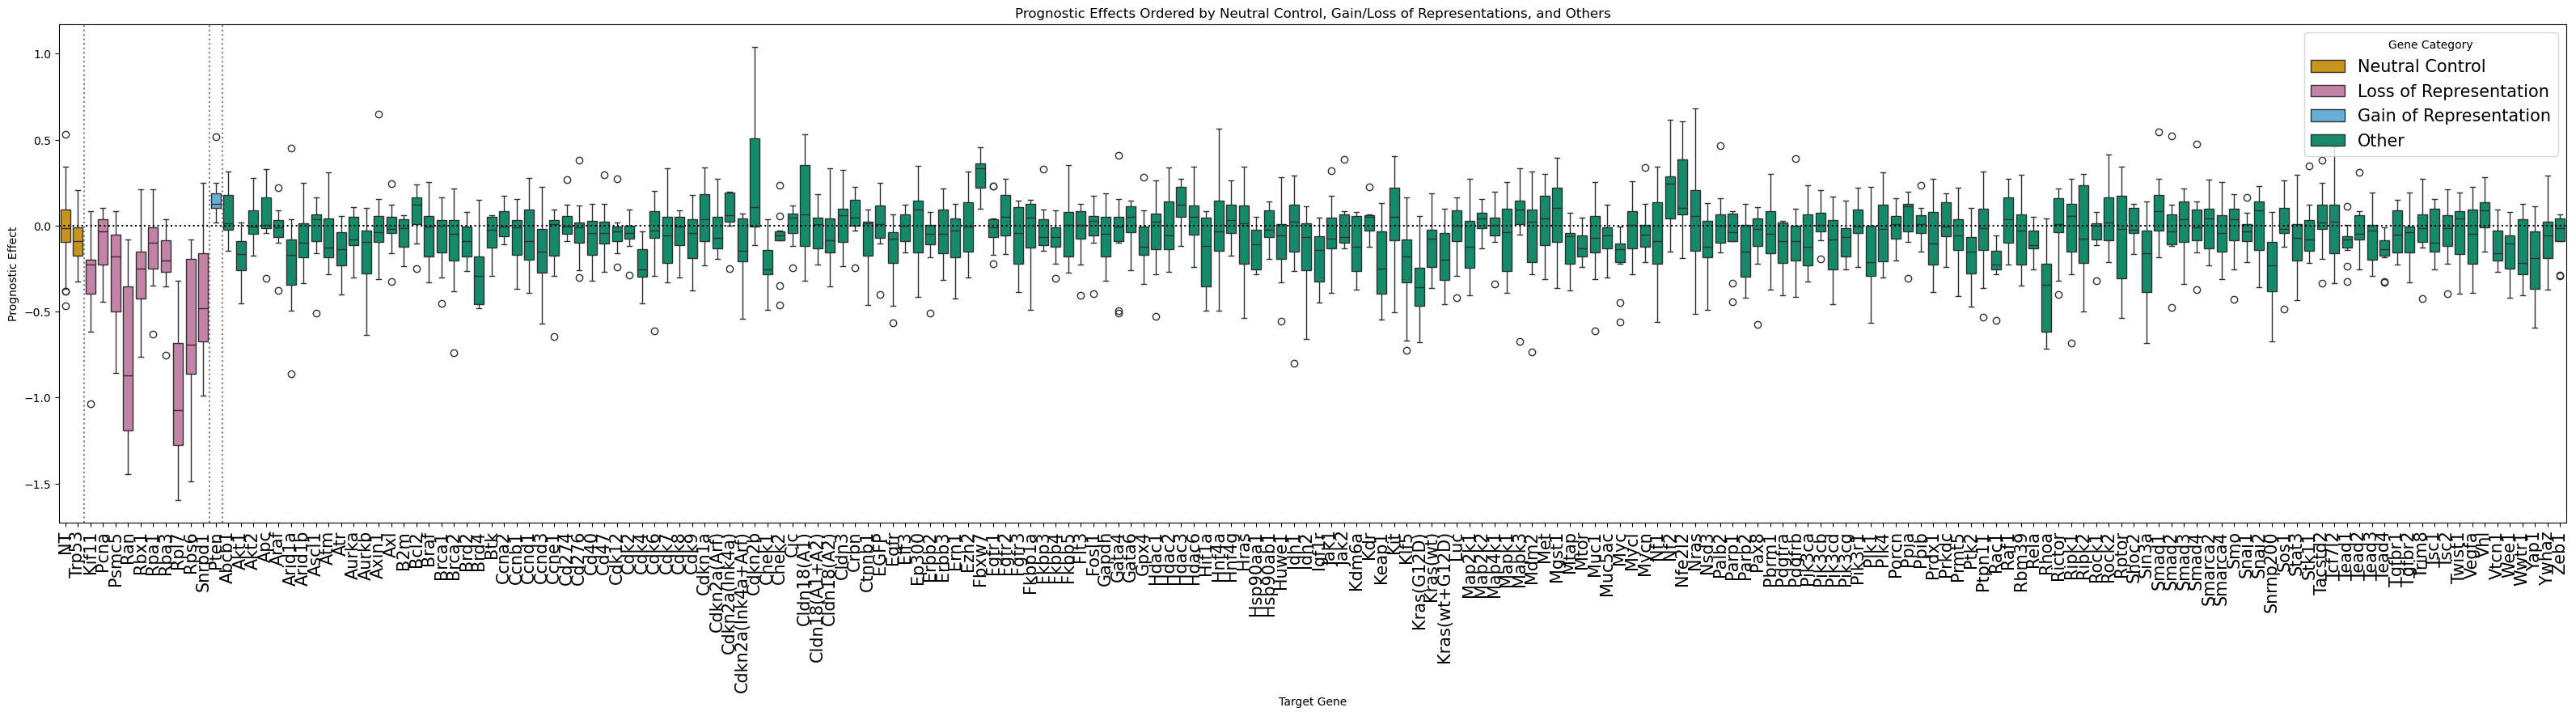

In [79]:
plt.figure(figsize=(40, 8))

# Use a distinct color palette for better differentiation
palette = {"Neutral Control": "#E69F00", 
           "Gain of Representation": "#56B4E9", 
           "Loss of Representation": "#CC79A7", 
           "Other": "#009E73"}

# Create the boxplot
ax = sns.boxplot(data=df_prognostic, x="Target_Gene", y="Prognostic_Effect", hue="Gene_Category", dodge=False, palette=palette)

# Add a horizontal reference line at 0
plt.axhline(y=0, color="black", linestyle="dotted")

# Compute correct category boundaries
neutral_control_count = df_prognostic[df_prognostic["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
loss_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
gain_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# Add vertical dotted lines at the correct positions
plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  # End of neutral controls
plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  # End of loss of representation
plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Customize the plot
plt.xticks(rotation=90, fontsize=10)  # Smaller font size for x-axis labels
plt.xlabel("Target Gene")
plt.ylabel("Prognostic Effect")
plt.title("Prognostic Effects Ordered by Neutral Control, Gain/Loss of Representations, and Others")
plt.xticks(rotation = 90, fontsize = 15)

# Move legend inside the plot at the top-right corner
plt.legend(title="Gene Category", loc="upper right", fontsize=15, frameon=True)

# Show the plot
plt.show()


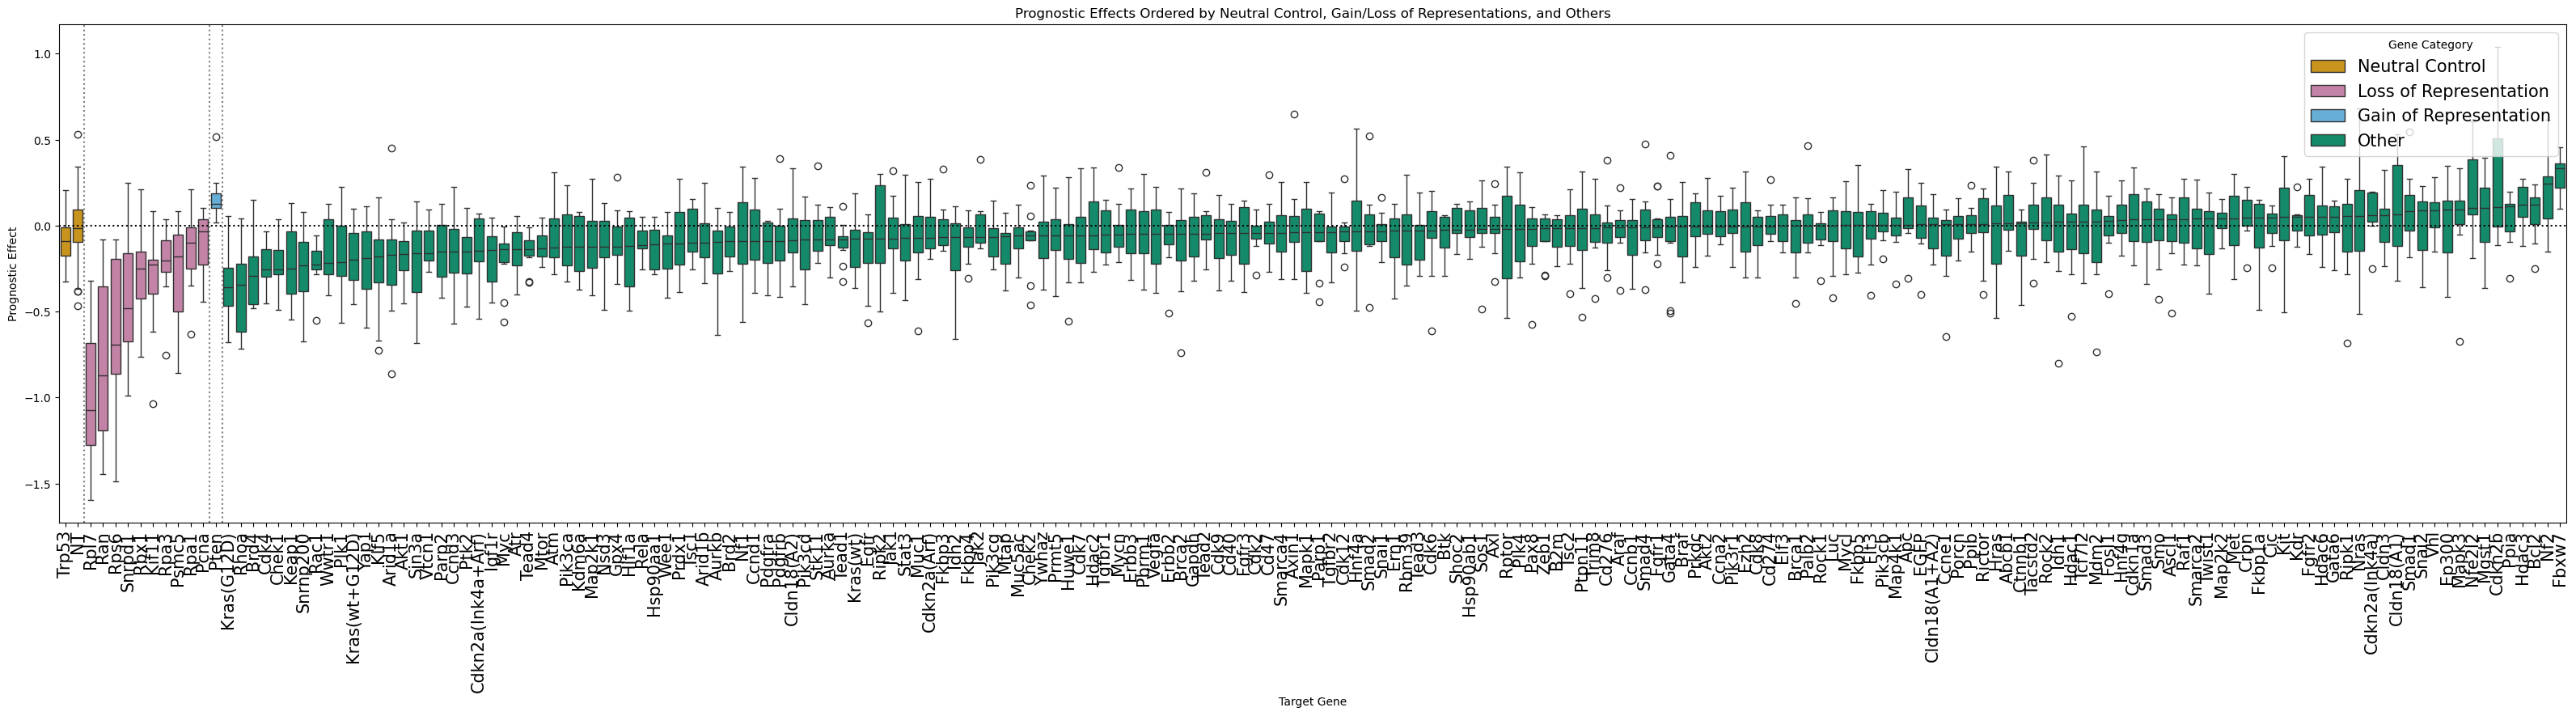

In [137]:
## 2nd plot of prognostic effect ordered by median of each gene_category
df_prognostic2 = df_prognostic.copy()

# Compute median Prognostic_Effect for each Target_Gene within each Gene_Category
gene_order = (
    df_prognostic2.groupby(["Sort_Order", "Target_Gene"])["Prognostic_Effect"]
    .median()
    .reset_index()
    .sort_values(["Sort_Order", "Prognostic_Effect"], ascending=[True, True])
)

# Update Target_Gene with the new categorical order
df_prognostic2["Target_Gene"] = pd.Categorical(
    df_prognostic2["Target_Gene"], 
    categories=gene_order["Target_Gene"], 
    ordered=True
)

# Now, re-plot with ordered Target_Gene
plt.figure(figsize=(40, 8))

# Define custom palette
palette = {
    "Neutral Control": "#E69F00", 
    "Gain of Representation": "#56B4E9", 
    "Loss of Representation": "#CC79A7", 
    "Other": "#009E73"
}

# Create the boxplot with the updated Target_Gene order
ax = sns.boxplot(
    data=df_prognostic2, 
    x="Target_Gene", 
    y="Prognostic_Effect", 
    hue="Gene_Category", 
    dodge=False, 
    palette=palette
)

# Add a horizontal reference line
plt.axhline(y=0, color="black", linestyle="dotted")

# Compute correct category boundaries
neutral_control_count = df_prognostic2[df_prognostic2["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
loss_of_representation_count = df_prognostic2[df_prognostic2["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
gain_of_representation_count = df_prognostic2[df_prognostic2["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# Add vertical dotted lines to separate categories
plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  
plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  
plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Customize the plot
plt.xticks(rotation=90, fontsize=15)
plt.xlabel("Target Gene")
plt.ylabel("Prognostic Effect")
plt.title("Prognostic Effects Ordered by Neutral Control, Gain/Loss of Representations, and Others")
plt.legend(title="Gene Category", loc="upper right", fontsize=15, frameon=True)

# Show the plot
plt.show()


In [156]:
print(gene_order)

     Sort_Order Target_Gene  Prognostic_Effect
1             1       Trp53          -0.090365
0             1          NT          -0.014155
9             2        Rpl7          -1.073116
5             2         Ran          -0.871127
10            2        Rps6          -0.690494
..          ...         ...                ...
147           4        Ppia           0.110300
89            4       Hdac3           0.123180
28            4        Bcl2           0.123611
128           4         Nf2           0.244013
73            4       Fbxw7           0.333511

[200 rows x 3 columns]


### Nonparametric null distribution of prognostic effect 
* Taking median of 10 shRNAs to derive bootstrapped empirical distribution from selected NT shRNAs

In [141]:
df_nt_prognostic = df_prognostic[df_prognostic["Target_Gene"] == "NT"]
display(df_nt_prognostic)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Prognostic_Effect,Gene_Category,Sort_Order
1147,NT_01,NT,0.005664,0.005860,-0.048990,Neutral Control,1
1148,NT_02,NT,0.008759,0.008220,0.091545,Neutral Control,1
1149,NT_03,NT,0.003065,0.002749,0.156982,Neutral Control,1
1150,NT_04,NT,0.004595,0.004578,0.005268,Neutral Control,1
1151,NT_05,NT,0.005373,0.005452,-0.021059,Neutral Control,1
...,...,...,...,...,...,...,...
1325,NT_95,NT,0.002423,0.002377,0.027353,Neutral Control,1
1326,NT_96,NT,0.005577,0.005650,-0.018866,Neutral Control,1
1327,NT_97,NT,0.003204,0.003882,-0.276967,Neutral Control,1
1328,NT_98,NT,0.006083,0.005843,0.058212,Neutral Control,1


In [145]:
# Generate bootstrapped null distribution (median prognostic effect of 10 NT shRNAs per replicate)
n_bootstraps = 100000

bootstrapped_nt_medians = np.array([
    df_nt_prognostic.sample(n=10, replace=True)["Prognostic_Effect"].median()
    for _ in range(n_bootstraps)
])

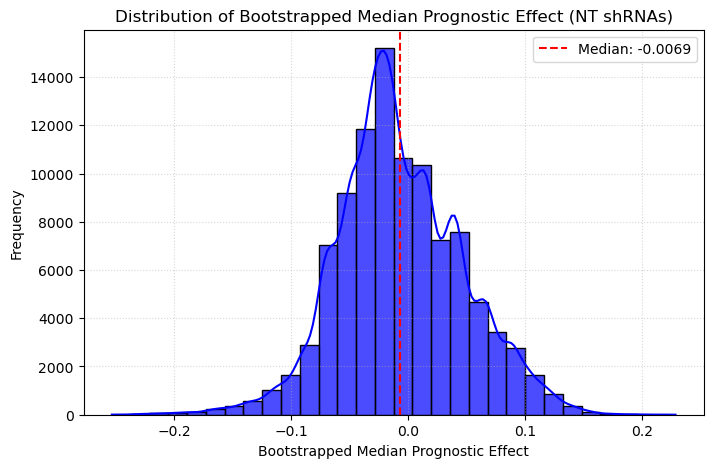

In [150]:
# Plot the distribution of bootstrapped median prognostic effects
plt.figure(figsize=(8, 5))
sns.histplot(bootstrapped_nt_medians, bins=30, kde=True, color="blue", alpha=0.7)
plt.axvline(np.mean(bootstrapped_nt_medians), color='red', linestyle='dashed', label=f"Median: {np.mean(bootstrapped_nt_medians):.4f}")
plt.xlabel("Bootstrapped Median Prognostic Effect")
plt.ylabel("Frequency")
plt.title("Distribution of Bootstrapped Median Prognostic Effect (NT shRNAs)")
plt.legend()
plt.grid(True, linestyle="dotted", alpha=0.5)

# Show plot
plt.show()

In [148]:
# Compute descriptive statistics for the bootstrapped null distribution
bootstrapped_stats = {
    "Mean": np.mean(bootstrapped_nt_medians),
    "Median": np.median(bootstrapped_nt_medians),
    "Standard Deviation": np.std(bootstrapped_nt_medians),
    "IQR (Interquartile Range)": np.percentile(bootstrapped_nt_medians, 75) - np.percentile(bootstrapped_nt_medians, 25),
    "5th Percentile": np.percentile(bootstrapped_nt_medians, 5),
    "95th Percentile": np.percentile(bootstrapped_nt_medians, 95),
    "Minimum": np.min(bootstrapped_nt_medians),
    "Maximum": np.max(bootstrapped_nt_medians),
}
print(bootstrapped_stats)

{'Mean': -0.006924557329965975, 'Median': -0.012714205656242173, 'Standard Deviation': 0.053565104996675966, 'IQR (Interquartile Range)': 0.06923947758603058, '5th Percentile': -0.08778453411105858, '95th Percentile': 0.0878918420671782, 'Minimum': -0.2531733596428093, 'Maximum': 0.22830140750201344}


## Genotype-specific drug (predictive) effects 
A vs. B <-> Treated (target gene vs NT) vs. Vehicle (target gene vs NT)
* ratio of ratios
* two dosages - 0.6nM and 3.5nM
* three time point - T7, T10, and T13

In [47]:
print(df_rtn["Sample_Description"].value_counts())

T10_Dox_0.6nM      2170
T10_Dox_3.5nM      2170
T10_Dox_Vehicle    2170
T13_Dox_0.6nM      2170
T13_Dox_3.5nM      2170
T13_Dox_Vehicle    2170
T4_Dox_NoTx        2170
T7_Dox_0.6nM       2170
T7_Dox_3.5nM       2170
T7_Dox_Vehicle     2170
T7_NoDox_NoTx      2170
Name: Sample_Description, dtype: int64


In [95]:
# Define all possible treatment vs vehicle comparisons for predictive effect calculation
timepoints = ["T7", "T10", "T13"]
dosages = ["0.6nM", "3.5nM"]

# Prepare an empty list to store results
predictive_effect_results = []

# Iterate over each combination of timepoint and dosage
for timepoint in timepoints:
    for dosage in dosages:
        # Define condition labels for treated (A) and vehicle (B)
        condition_A = f"{timepoint}_Dox_{dosage}"
        condition_B = f"{timepoint}_Dox_Vehicle"
        
        # Filter data for both conditions
        df_A = df_rtn[df_rtn["Sample_Description"] == condition_A][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_A"})
        df_B = df_rtn[df_rtn["Sample_Description"] == condition_B][["shRNA_ID", "Target_Gene", "RTN"]].rename(columns={"RTN": "RTN_B"})
        
        # Merge the two datasets on shRNA_ID and Target_Gene
        df_predictive = df_A.merge(df_B, on=["shRNA_ID", "Target_Gene"], how="inner")
        
        # Compute the predictive effect as log2(RTN_A / RTN_B)
        df_predictive["Predictive_Effect"] = np.log2(df_predictive["RTN_A"] / df_predictive["RTN_B"])
        
        # Add timepoint and dosage for reference
        df_predictive["Timepoint"] = timepoint
        df_predictive["Dosage"] = dosage
        
        # Append results
        predictive_effect_results.append(df_predictive)

# Concatenate all results into a single dataframe
df_predictive_effect = pd.concat(predictive_effect_results, ignore_index=True)

# Assign categories for sorting
df_predictive_effect["Gene_Category"] = "Other"  # Default category
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(neutral_control_target_genes), "Gene_Category"] = "Neutral Control"
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(loss_of_representation_target_genes), "Gene_Category"] = "Loss of Representation"
df_predictive_effect.loc[df_predictive_effect["Target_Gene"].isin(gain_of_representation_target_genes), "Gene_Category"] = "Gain of Representation"


# Sort Target_Gene first by category, then alphabetically within each category
df_predictive_effect["Sort_Order"] = df_predictive_effect["Gene_Category"].map({"Neutral Control": 1, 
                                                                  "Loss of Representation": 2, 
                                                                  "Gain of Representation": 3, 
                                   
                                                                                "Other": 4})
df_predictive_effect = df_predictive_effect.sort_values(by=["Sort_Order", "Target_Gene"])

# Get unique timepoint-dosage combinations
timepoint_dosage_combinations = df_predictive_effect[["Timepoint", "Dosage"]].drop_duplicates().sort_values(by=["Timepoint", "Dosage"])

print(timepoint_dosage_combinations)

      Timepoint Dosage
5487        T10  0.6nM
7657        T10  3.5nM
9827        T13  0.6nM
11997       T13  3.5nM
1147         T7  0.6nM
3317         T7  3.5nM


In [96]:
display(df_predictive_effect)
df_predictive_effect.to_csv(os.path.join(proj_dir, "data/predictive_effect.csv"), index = False)

,shRNA_ID,Target_Gene,RTN_A,RTN_B,Predictive_Effect,Timepoint,Dosage,Gene_Category,Sort_Order
1147,NT_01,NT,0.006027,0.005881,0.035514,T7,0.6nM,Neutral Control,1
1148,NT_02,NT,0.008253,0.008569,-0.054145,T7,0.6nM,Neutral Control,1
1149,NT_03,NT,0.002805,0.002901,-0.048412,T7,0.6nM,Neutral Control,1
1150,NT_04,NT,0.004478,0.004269,0.069105,T7,0.6nM,Neutral Control,1
1151,NT_05,NT,0.005208,0.005561,-0.094459,T7,0.6nM,Neutral Control,1
...,...,...,...,...,...,...,...,...,...
13015,Zeb1_06,Zeb1,0.002341,0.002152,0.121645,T13,3.5nM,Other,4
13016,Zeb1_07,Zeb1,0.003508,0.003378,0.054599,T13,3.5nM,Other,4
13017,Zeb1_08,Zeb1,0.002686,0.003017,-0.167363,T13,3.5nM,Other,4
13018,Zeb1_09,Zeb1,0.006507,0.006237,0.060981,T13,3.5nM,Other,4


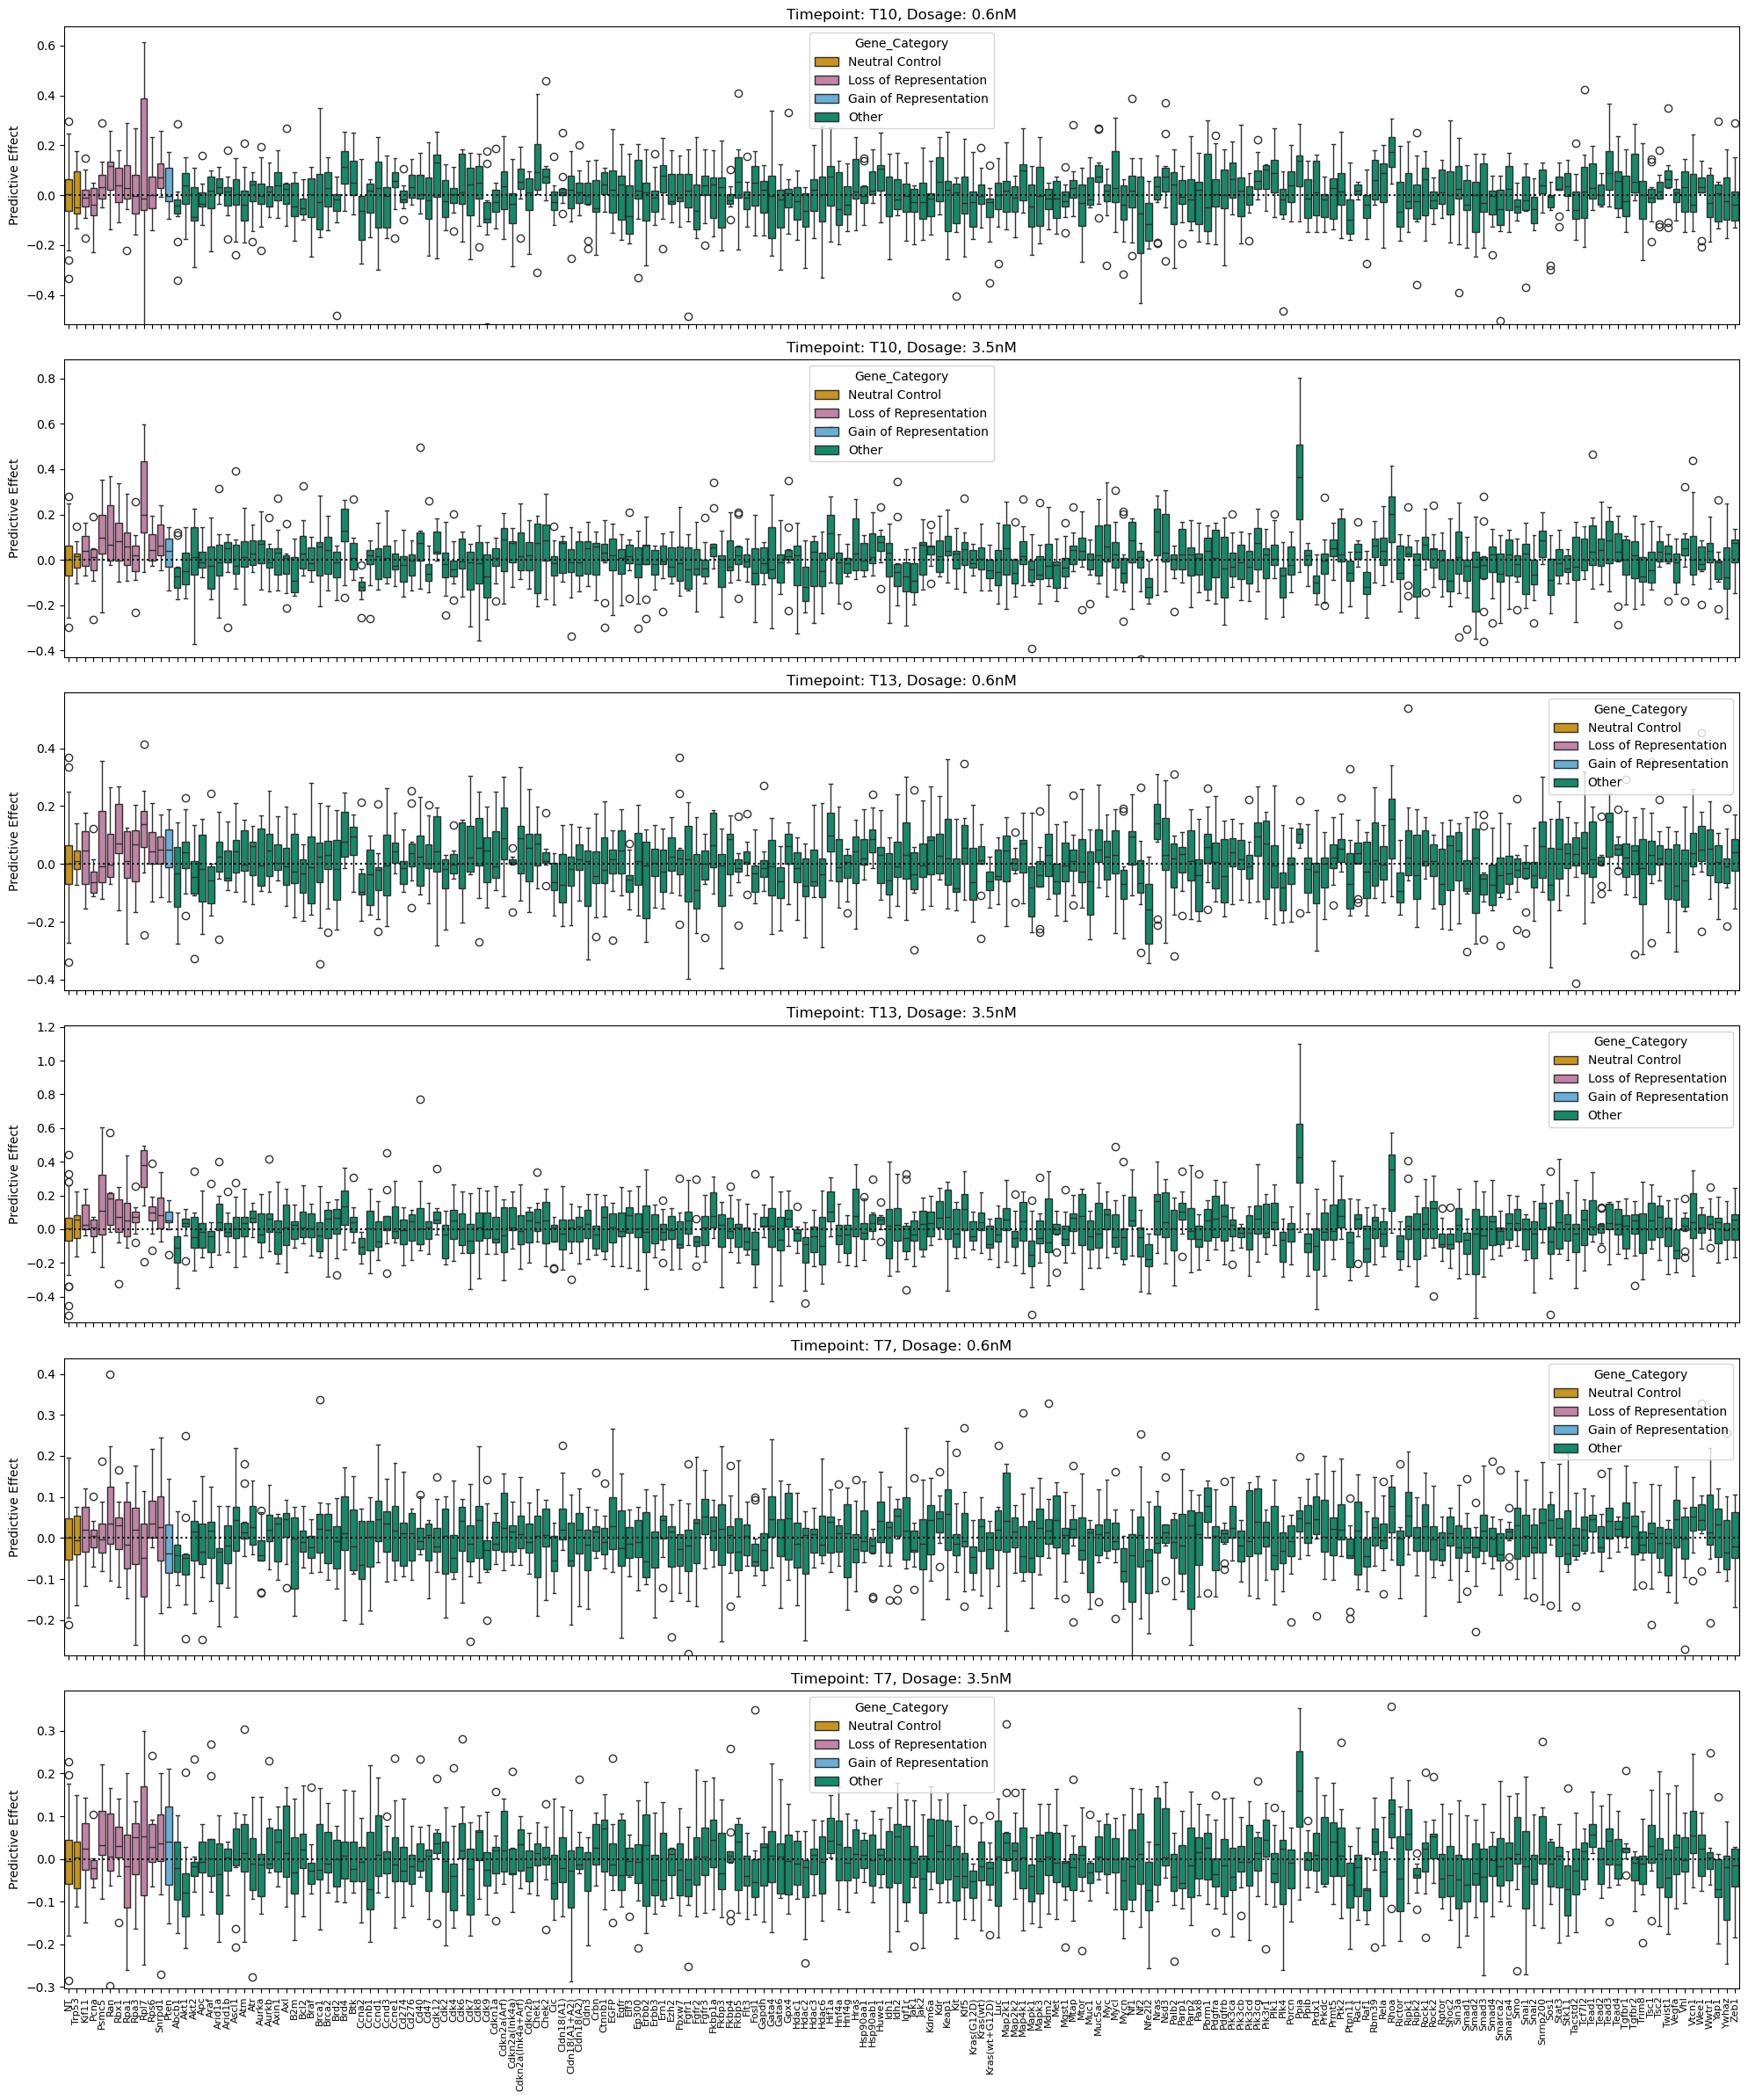

In [98]:
# # Compute correct category boundaries
# neutral_control_count = df_prognostic[df_prognostic["Gene_Category"] == "Neutral Control"]["Target_Gene"].nunique()
# loss_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Loss of Representation"]["Target_Gene"].nunique()
# gain_of_representation_count = df_prognostic[df_prognostic["Gene_Category"] == "Gain of Representation"]["Target_Gene"].nunique()

# # Add vertical dotted lines at the correct positions
# plt.axvline(x=neutral_control_count - 0.5, color="gray", linestyle="dotted")  # End of neutral controls
# plt.axvline(x=neutral_control_count + loss_of_representation_count - 0.5, color="gray", linestyle="dotted")  # End of loss of representation
# plt.axvline(x=neutral_control_count + loss_of_representation_count + gain_of_representation_count - 0.5, color="gray", linestyle="dotted")

# Define grid size (rows = number of combinations, 1 column)
num_rows = len(timepoint_dosage_combinations)
num_cols = 1

# Create the grid plot with individually scaled y-axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4), sharex=True)

# Ensure axes is always a list for iteration
if num_rows == 1:
    axes = [axes]

# Plot each timepoint-dosage combination in a separate row with individual y-axis scaling
for ax, (timepoint, dosage) in zip(axes, timepoint_dosage_combinations.itertuples(index=False)):
    subset = df_predictive_effect[(df_predictive_effect["Timepoint"] == timepoint) & (df_predictive_effect["Dosage"] == dosage)]
    
    sns.boxplot(data=subset, x="Target_Gene", y="Predictive_Effect", hue="Gene_Category", dodge=False, ax=ax, 
                palette=palette)
    
    ax.axhline(y=0, color="black", linestyle="dotted")  # Add reference line at 1.0
    ax.set_title(f"Timepoint: {timepoint}, Dosage: {dosage}", fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Predictive Effect")
    ax.tick_params(axis='x', rotation=90, labelsize=8)

    # Adjust y-axis range dynamically based on the subset
    ax.set_ylim(subset["Predictive_Effect"].min() * 0.9, subset["Predictive_Effect"].max() * 1.1)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Generate median and its bootstrapped 95% CI 
For RTN_A, RTN_B, and Predictive_Effect of each Target_Gene

In [99]:
file_path_summary_predictive_effect = os.path.join(proj_dir, "data/predictive_effect_bootstrapped_summary.csv")
rerun_predictive_effect_bootstrapping = True

if os.path.exists(file_path_summary_predictive_effect) and not rerun_predictive_effect_bootstrapping:

    df_summary_predictive_effect = pd.read_csv(file_path_summary_predictive_effect)
    
else: 
    df_summary_predictive_effect = df_predictive_effect.groupby(["Target_Gene", "Timepoint", "Dosage"]).apply(
        lambda df: pd.Series({
            "RTN_A_median": df["RTN_A"].median(),
            "RTN_A_CI_lower": bootstrap_median_ci(df["RTN_A"])[0],
            "RTN_A_CI_upper": bootstrap_median_ci(df["RTN_A"])[1],
            "RTN_B_median": df["RTN_B"].median(),
            "RTN_B_CI_lower": bootstrap_median_ci(df["RTN_B"])[0],
            "RTN_B_CI_upper": bootstrap_median_ci(df["RTN_B"])[1],
            "Predictive_Effect_median": df["Predictive_Effect"].median(),
            "Predictive_Effect_CI_lower": bootstrap_median_ci(df["Predictive_Effect"])[0],
            "Predictive_Effect_CI_upper": bootstrap_median_ci(df["Predictive_Effect"])[1],
        })
    ).reset_index()
    df_summary_predictive_effect.to_csv(os.path.join(proj_dir, "data/predictive_effect_bootstrapped_summary.csv"), index = False)

In [100]:
display(df_summary_predictive_effect)

,Target_Gene,Timepoint,Dosage,RTN_A_median,RTN_A_CI_lower,RTN_A_CI_upper,RTN_B_median,RTN_B_CI_lower,RTN_B_CI_upper,Predictive_Effect_median,Predictive_Effect_CI_lower,Predictive_Effect_CI_upper
0,Abcb1,T10,0.6nM,0.002923,0.002269,0.005064,0.003058,0.002808,0.005012,-0.040360,-0.115548,-0.010993
1,Abcb1,T10,3.5nM,0.003187,0.002421,0.004693,0.003058,0.002387,0.005012,-0.073336,-0.126676,0.030043
2,Abcb1,T13,0.6nM,0.003024,0.002439,0.004965,0.002922,0.002507,0.005039,-0.032341,-0.156562,0.066798
3,Abcb1,T13,3.5nM,0.002937,0.002252,0.004439,0.002922,0.002346,0.005039,-0.107787,-0.203282,-0.032588
4,Abcb1,T7,0.6nM,0.003003,0.002350,0.004900,0.003122,0.002373,0.004680,-0.041436,-0.084122,-0.012193
...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Zeb1,T10,3.5nM,0.003905,0.003008,0.005255,0.003747,0.002821,0.005120,0.074711,-0.031210,0.104519
1196,Zeb1,T13,0.6nM,0.003844,0.002710,0.005091,0.003421,0.002809,0.005167,0.040897,-0.036186,0.112591
1197,Zeb1,T13,3.5nM,0.003822,0.002686,0.005044,0.003421,0.002775,0.005162,0.057790,-0.099483,0.096593
1198,Zeb1,T7,0.6nM,0.003773,0.002785,0.005447,0.003993,0.002928,0.005191,-0.020368,-0.089932,0.078562


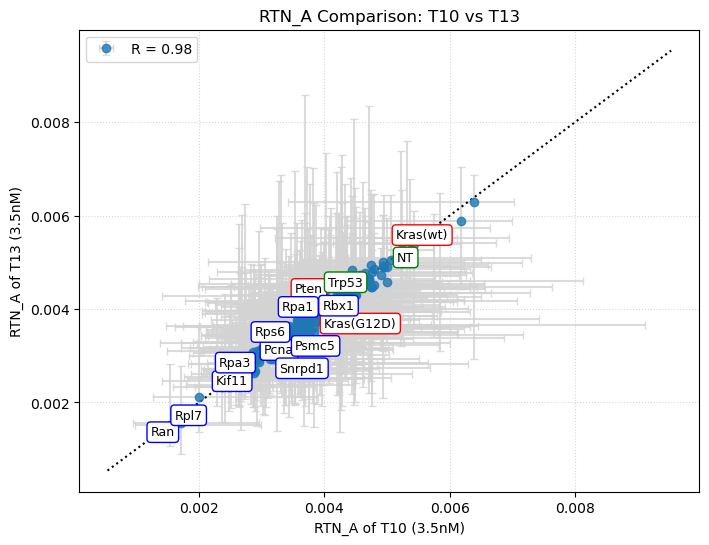

In [128]:
plot_bootstrapped_scatter(df_summary_predictive_effect, "T10", "3.5nM", "T13", "3.5nM", "RTN_A")

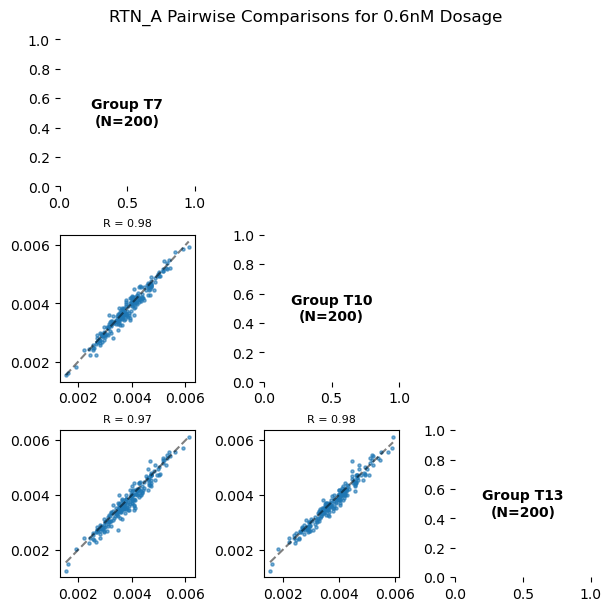

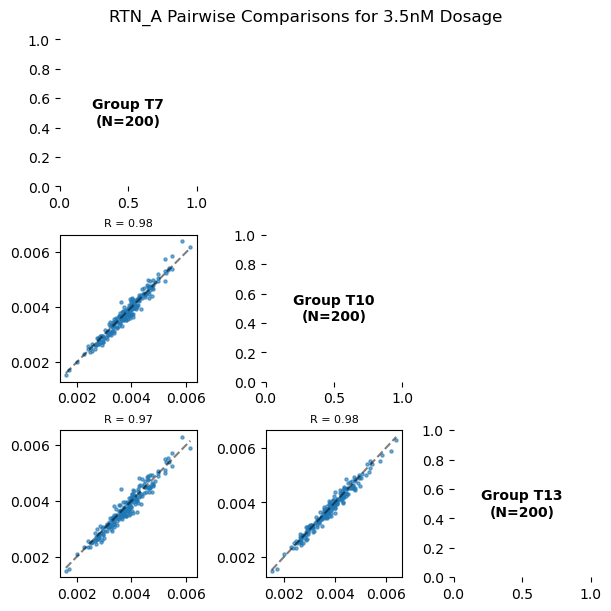

In [131]:
# Generate optimized grid plot for RTN_A at 0.6nM and 3.5nM
plot_optimized_grid(df_summary_predictive_effect, "0.6nM", "RTN_A")
plot_optimized_grid(df_summary_predictive_effect, "3.5nM", "RTN_A")

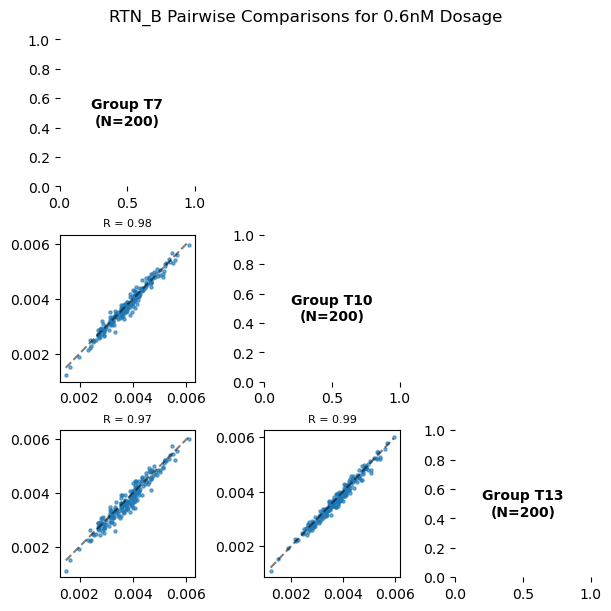

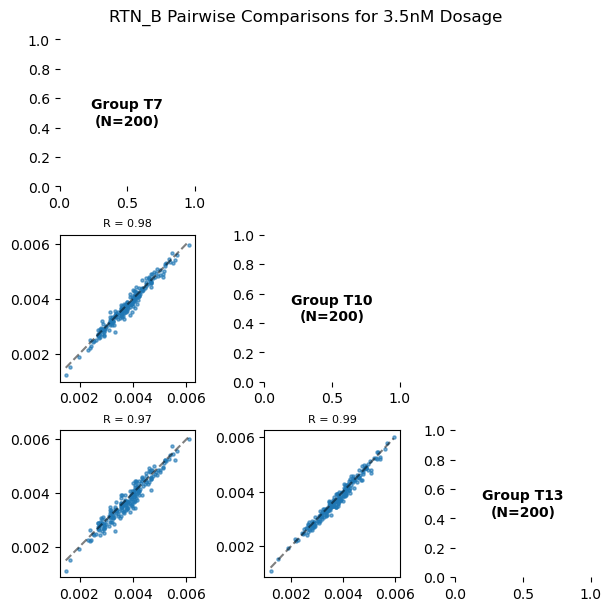

In [132]:
# Generate optimized grid plot for RTN_B at 0.6nM and 3.5nM
plot_optimized_grid(df_summary_predictive_effect, "0.6nM", "RTN_B")
plot_optimized_grid(df_summary_predictive_effect, "3.5nM", "RTN_B")

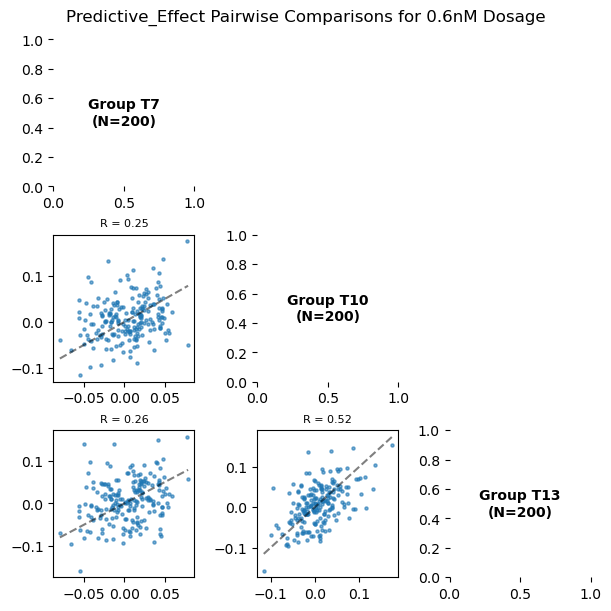

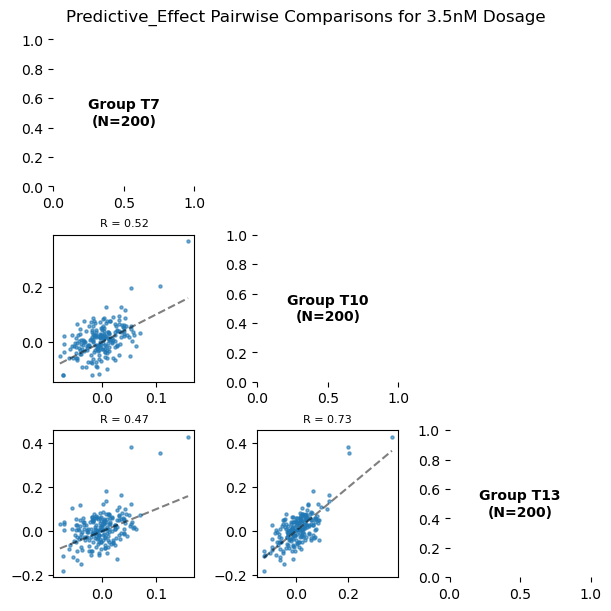

In [133]:
# Generate optimized grid plot for Predictive effect at 0.6nM and 3.5nM
plot_optimized_grid(df_summary_predictive_effect, "0.6nM", "Predictive_Effect")
plot_optimized_grid(df_summary_predictive_effect, "3.5nM", "Predictive_Effect")